Load the libraries

In [ ]:
!pip install tensorflow-addons

In [2]:
import tensorflow as tf 
import tensorflow_addons as tfa
from skimage.transform import warp, AffineTransform
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import math
import seaborn as sns
tf.random.set_seed(42)

# Data Loading and preprocessing

Link dataset in tfrecords: https://drive.google.com/open?id=1sz5MURqR_S_-f4niCx3dYeMXAljowWRt

In [65]:
@tf.function
def apply_random_scaling(image, minval=-.02, maxval=.02):
    param = tf.random.uniform([], minval=minval, maxval=maxval)
    source_size = image.shape
    target_size = tf.cast(source_size[0]*(1.0+param), tf.int32), tf.cast(source_size[1]*(1.0+param), tf.int32)
    output = tf.image.resize_with_crop_or_pad(tf.image.resize(image, target_size), source_size[0], source_size[1])
    return output, param

def apply_random_shearing(image, minval=-5., maxval=5.):
    #param = tf.random.uniform([], minval=tf.math.atan(minval/image.shape[1]), maxval=tf.math.atan(maxval/image.shape[1]))
    #param = tf.random.uniform([], minval=tf.math.atan(), maxval=tf.math.atan(maxval/image.shape[1]))
    param = np.random.uniform(low=minval, high=maxval)
    output = warp(np.array(image), AffineTransform(shear=np.arctan(param/image.shape[1])).inverse)
    return output, param
@tf.function
def apply_random_rotation(image, minval=-7, maxval=7):
    param = tf.random.uniform([], minval=minval, maxval=maxval)
    output = tfa.image.rotate(image, param*math.pi/180.0, interpolation='BILINEAR')
    return output, param


def apply_test_time_augmentation(image, labels, image_id):
    '''Implements TTA, https://arxiv.org/pdf/1911.06475.pdf pag13:
    
    (...) for each test CXR, we applied a random 
    transformation (amongst horizontal flipping, 
    rotating ±7 degrees, scaling±2%,and shearing±5 pixels) 10 times (...)
    
    :param image - the input image
    :param labels - the labels associated with the image
    :param image_id - an ordinal or id associated with the image
    
    :returns - a DataFrame containing one row for each generated image (+1 for the original one), a list of generated images and labels. 
    The dataframe contains the augmentation method used, the parameter and the image/label filenames.
    '''
    dataframe = pd.DataFrame()
    image_list = list()
    image_list.append((image, labels))
    
    dataframe = dataframe.append({'image_id':image_id,
                                      'tta_id':0,
                                      'image_fn':'{}_{}_image.npy'.format(image_id, 0),
                                      'labels_fn':'{}_label.npy'.format(image_id),
                                      'method':'ORIGINAL',
                                      'param':0.0}, ignore_index=True)
    
    for i in range(1, 11):

        random_function = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)

        output = image
        param = tf.constant(0.0)        
        
        if tf.equal(random_function, 0):
            output = tf.image.flip_left_right(image)
            param = tf.constant(0.0)
            method = 'FLIP'
        if tf.equal(random_function, 1):
            output, param = apply_random_rotation(image)
            method = 'ROTATION'
        if tf.equal(random_function, 2):
            output, param = apply_random_scaling(image)
            method = 'SCALING'
        if tf.equal(random_function, 3):
            output, param = apply_random_shearing(image)
            method = 'SHEAR'
        image_list.append((output, labels))
        
        dataframe = dataframe.append({'image_id':image_id,
                                      'tta_id':int(i),
                                      'image_fn':'{}_{}_image.npy'.format(image_id, i),
                                      'labels_fn':'{}_label.npy'.format(image_id),
                                      'method':method,
                                      'param':float(param)}, ignore_index=True)
    return dataframe, image_list


def record_parser(example, image_size=224):
    example_fmt = {
        'label': tf.io.FixedLenFeature([14], tf.float32),
        'image': tf.io.FixedLenFeature([],tf.string, default_value='')}
    parsed = tf.io.parse_single_example(example, example_fmt)
    image = tf.io.decode_png(parsed["image"],channels=3)
    image.set_shape([image_size, image_size, 3])
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, parsed['label']

def normalize_image(img,labels):
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    img = (img - imagenet_mean) / imagenet_std
    return img,labels

def make_dataset(filename, image_size=224):
  base_path = 'datasets/'
  full_path = os.path.join(base_path,filename)
  dataset = tf.data.TFRecordDataset(full_path)
  parser = lambda x, size=image_size: record_parser(x, image_size=size)
  parsed_dataset = dataset.map(parser,num_parallel_calls = tf.data.experimental.AUTOTUNE)
  parsed_dataset = parsed_dataset.map(normalize_image,num_parallel_calls = tf.data.experimental.AUTOTUNE)
  return parsed_dataset

def make_tta_dataset(csv_path, test_dataset_path='test_set_cropped.tfrecords', image_size=224):
    '''
    TTA Dataset is built upon the test set. If the csv file exists in the given path, then this function use it to load the dataset.
    Otherwise first the test dataset is loaded and each image is saved in a different numpy file. 
    '''
    tta_images = list()
    tta_labels = list()
    folder = os.path.dirname(csv_path)
    
    if not os.path.isfile(csv_path):
        print("Dataset not found. Generating...")
        # Generate dataset
        # Load test dataset
        
        os.makedirs(folder, exist_ok=True)
        test_dataset = make_dataset(test_dataset_path).prefetch(1)
        # Apply augmentation
        tta_dataset = list()
        tta_csv = pd.DataFrame()
        for r, record in enumerate(test_dataset):
            aug_dataframe, aug_images = apply_test_time_augmentation(record[0], record[1], r)
            tta_csv = tta_csv.append(aug_dataframe, ignore_index=True)
            for (_, (image_fn, labels_fn)), (aug_image, aug_label) in zip(aug_dataframe[['image_fn', 'labels_fn']].iterrows(), aug_images):
                np.save(os.path.join(folder, image_fn), aug_image)
                if _ == 0:
                    np.save(os.path.join(folder, labels_fn), aug_label)
        tta_csv.to_csv(csv_path)
    
    print("Loading dataset "+ csv_path)
    # Load dataset
    csv = pd.read_csv(csv_path, index_col=0)
    for g, augmentation_group in csv.loc[csv['method'] != 'ORIGINAL'].groupby(['image_id']):
        current_aug = list()
        for _, (image_fn, labels_fn) in augmentation_group[['image_fn', 'labels_fn']].iterrows():
            current_aug.append(np.load(os.path.join(folder, image_fn)))
            label = np.load(os.path.join(folder, labels_fn))
        tta_images.append(np.stack(current_aug))
        tta_labels.append(label)
    return tf.data.Dataset.from_tensor_slices((tta_images, tta_labels))
        

batch_size = 64
#train_dataset = make_dataset('training_cropped.tfrecords').shuffle(buffer_size=128).batch(batch_size, drop_remainder=True).prefetch(1)
#val_dataset = make_dataset('validation_cropped.tfrecords').shuffle(buffer_size=128).batch(batch_size, drop_remainder=True).prefetch(1)
#train_dataset = make_dataset('training_cropped.tfrecords').batch(batch_size, drop_remainder=True).prefetch(1)

# UNCOMMENT TO ENABLE TRAINING
# train_dataset = make_dataset('conditional_training.tfrecords').shuffle(buffer_size=128).batch(batch_size, drop_remainder=True).prefetch(1)
val_dataset = make_dataset('validation_cropped.tfrecords').batch(batch_size, drop_remainder=True).prefetch(1)
# test_dataset = make_dataset('test_set_cropped.tfrecords').batch(batch_size, drop_remainder=False).prefetch(1)

tta_dataset = make_tta_dataset('datasets/tta_dataset/tta.csv')

# TODO: Since we cannot convert the full pipeline to tensorflow (due to shearing depending on Skimage), the make tta dataset will:
# 1) Compute the dataset if not already present at the given path (using the classical for structure)
# 2) Load the dataset from npy files as a tensorflow dataset

# Model

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet201,DenseNet121,DenseNet169
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Activation, Lambda
from tensorflow.keras.models import Model

base_model = DenseNet121(include_top=False,
                             weights='imagenet',
                             input_shape=(224, 224, 3))



x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(14, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

def step_decay(epoch):
  initial_lr = 1e-4
  drop = 0.1
  return initial_lr * np.power(drop,epoch)

outputFolder = '/content/drive/My Drive/Models320/VGG19'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath=outputFolder+"/model-{epoch:02d}.hdf5"

lr_scheduler = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_AUC',mode='max',patience=4)
checkpoint_cb = ModelCheckpoint(filepath,save_best_only = False,save_weights_only = False,
                               save_freq='epoch',verbose=False)


opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
callbacks = [lr_scheduler,checkpoint_cb,early_stopping]

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy','AUC'])

In [ ]:
%%time
history = model.fit(train_dataset,
          epochs=5,
          validation_data=val_dataset,
          callbacks=callbacks,
          verbose=1,initial_epoch = 0)

# Load Models

Link alla cartella contenente i modelli trainati: https://drive.google.com/open?id=1EkuS27OzYyQ4fqfiNQdcrO6nQkyKBJ9B

In [4]:
from tensorflow.keras.models import load_model

base_path = './Models/'
def load_models(base_path):
  models = []
  model_names = sorted(os.listdir(base_path))
  for model in model_names:
    print('loading model: {}'.format(model))
    models.append(load_model(os.path.join(base_path,model)))
  return models, model_names

models, model_names = load_models(base_path)

loading model: densenet121_model.hdf5
loading model: densenet169_model.hdf5
loading model: densenet201_model.hdf5
loading model: inceptionresnetv2_model.hdf5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/core.py:1030: UserWarning: keras_applications.inception_resnet_v2 is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


loading model: vgg16_model.hdf5
loading model: vgg19_model.hdf5
loading model: xception_model.hdf5


# Model Predictions

Test Time Augmentation (TTA) produces each prediction by averaging the result of 10 augmented samples

In [5]:
tta_predictions = list()
test_Y = list()
for augmented_block, label in tta_dataset:
    test_Y.append(label.numpy())
    models_predictions = list()
    for model in models:
        models_predictions.append(np.stack([model.predict(img[tf.newaxis, ...]) for img in tf.unstack(augmented_block)]))
    tta_predictions.append(np.stack(models_predictions))
test_Y = np.array(test_Y)    
tta_predictions = np.stack(tta_predictions).squeeze().transpose(1, 0, 2, 3) # Prediction for each augmented image and model
test_predictions = tta_predictions.mean(axis=2)

## TTA Robustness

14

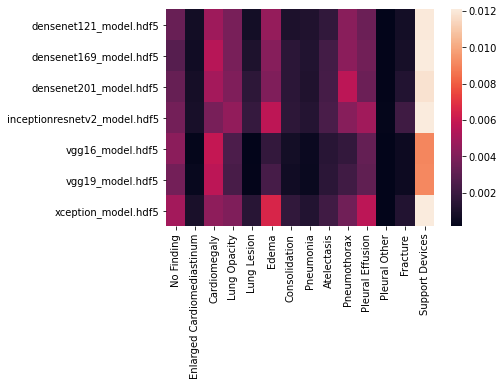

In [20]:
dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']



# Checking what predictions/models are more robust to TTA

robustness = pd.DataFrame(np.mean(np.var(tta_predictions, axis=(2)), axis=0), columns=dummy_labels, index=model_names)
sns.heatmap(robustness, robust=True)

## Simple Mean

In [45]:
model_predictions = tta_predictions.mean(axis=2).mean(axis=0) # Means over the augmentations (one record per CXT)

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


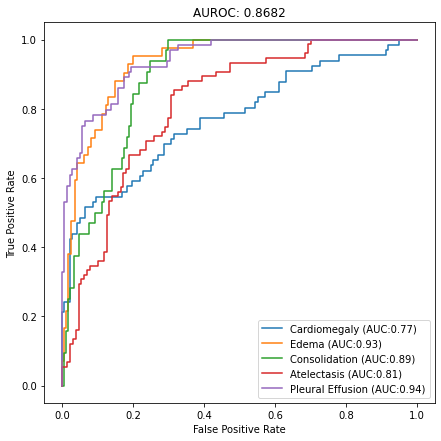

In [46]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

target_labels = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
fig, ax = plt.subplots(1,1, figsize = (7, 7))


j = 1
aurocs = []
for (i, label) in enumerate(dummy_labels):
  fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), model_predictions[:,i])
  if (label in target_labels):
    #ax = fig.add_subplot(2,3,j)
    ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
    aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))



# Weighted Predictions

In [47]:
from scipy.stats import entropy

def make_weighted_predictions(predictions):
  entropies = entropy([predictions,1-predictions],base = 2)
  return np.average(predictions,axis=0,weights=1-entropies)

weighted_predictions = make_weighted_predictions(tta_predictions.mean(axis=2))


No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


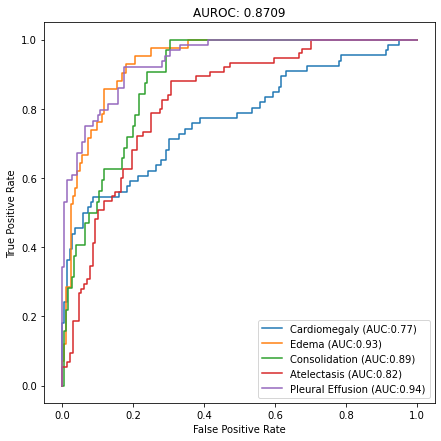

In [50]:
fig, ax = plt.subplots(1,1, figsize = (7, 7))
j = 1
aurocs = []
for (i, label) in enumerate(dummy_labels):
  fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), weighted_predictions[:,i])
  if (label in target_labels):
    #ax = fig.add_subplot(2,3,j)
    ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
    aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))


# Majority Voting

Majority voting with threshold 0.5

In [84]:
binary_pred = test_predictions >= 0.5
binary_pred = binary_pred.astype(int)
votes = binary_pred.sum(axis=0)
final_pred = votes >=4
final_pred = final_pred.astype(int)

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


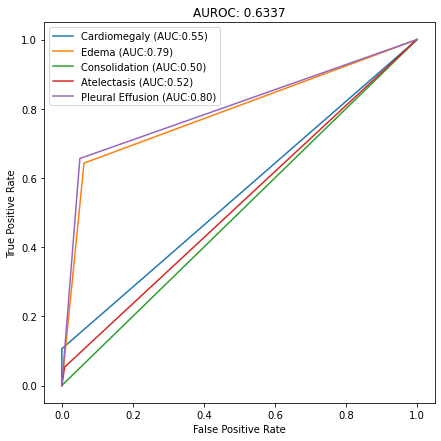

In [85]:
fig, ax = plt.subplots(1,1, figsize = (7, 7))
j = 1
aurocs = []
for (i, label) in enumerate(dummy_labels):
  fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), final_pred[:,i])
  if (label in target_labels):
    #ax = fig.add_subplot(2,3,j)
    ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
    aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))


Majority voting with threshold 0.2

In [86]:
binary_pred = test_predictions >= 0.2
binary_pred = binary_pred.astype(int)
votes = binary_pred.sum(axis=0)
final_pred = votes >=4
final_pred = final_pred.astype(int)

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


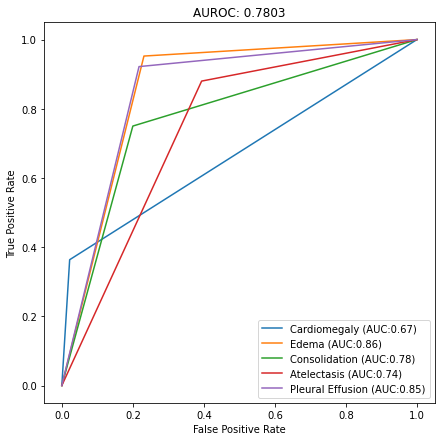

In [87]:
fig, ax = plt.subplots(1,1, figsize = (7, 7))
j = 1
aurocs = []
for (i, label) in enumerate(dummy_labels):
  fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), final_pred[:,i])
  if (label in target_labels):
    #ax = fig.add_subplot(2,3,j)
    ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
    aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))


# Voting

In [89]:
from scipy.stats import entropy

entropies = entropy([predictions,1-predictions],base = 2)

In [90]:
binary_pred = test_predictions >= 0.2
binary_pred = binary_pred.astype(int)
final_pred = np.average(binary_pred,axis=0)
final_pred = final_pred.astype(float)

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


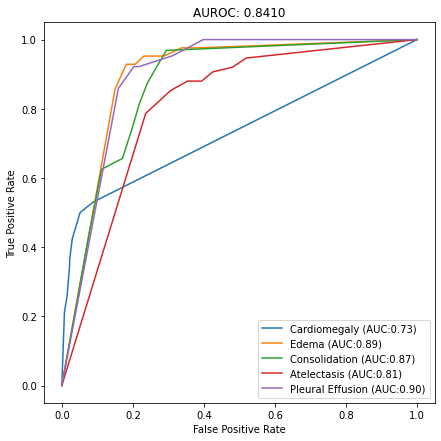

In [91]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

target_labels = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']

fig, ax = plt.subplots(1,1, figsize = (7, 7))
j = 1
aurocs = []
for (i, label) in enumerate(dummy_labels):
  fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), final_pred[:,i])
  if (label in target_labels):
    #ax = fig.add_subplot(2,3,j)
    ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
    aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))


# Single model performance


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/

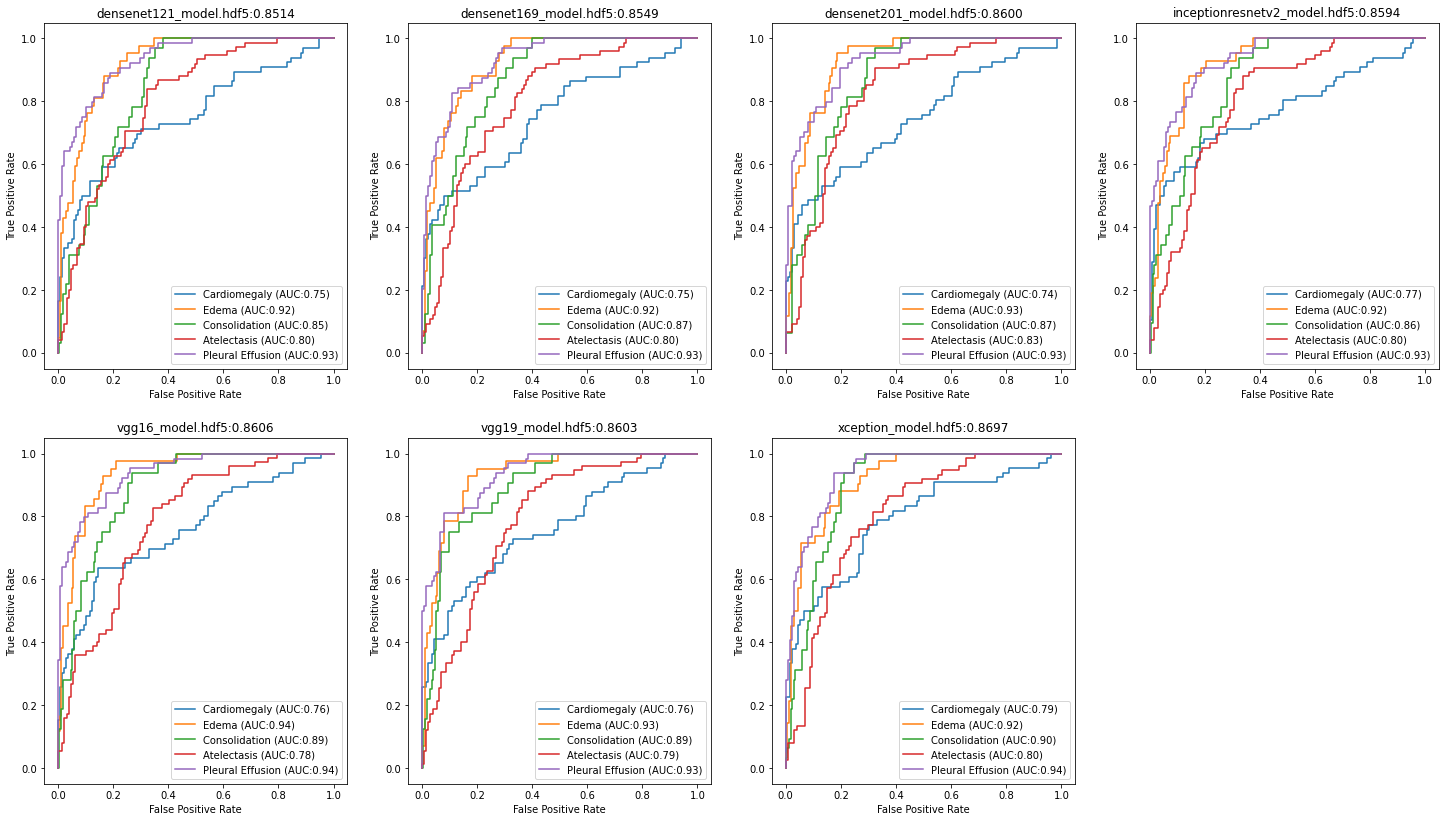

In [92]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

target_labels = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']

titles = model_names
#fig, c_ax = plt.subplots(2,3, figsize = (15, 10))
fig = plt.figure(figsize=(25,14))


j = 1
for model_prediction in test_predictions:
  aurocs= []
  ax = fig.add_subplot(2,4,j)
  for (i, label) in enumerate(dummy_labels):
      fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), model_prediction[:,i])
      if (label in target_labels):
        #ax = fig.add_subplot(2,3,j)
        ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
        aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('{}:{:0.4f}'.format(titles[j-1],np.mean(aurocs)))
  j+=1 
    


# Stacking

In [ ]:
from tensorflow.keras.models import load_model

base_path = '/content/drive/My Drive/Models'
def load_models(base_path):
  models = []
  for model in os.listdir(base_path):
    print('loading model: {}'.format(model))
    models.append(load_model(os.path.join(base_path,model)))
  return models

models = load_models(base_path)

In [105]:
def build_meta_learner_dataset(models,dataset):
  predictions = []
  for model in models: 
    predictions.append(model.predict(dataset))
  predictions = np.array(predictions)
  new_pred = []
  for i in range(predictions.shape[1]):
    new_pred.append(predictions[:,i])
  new_pred = np.array(new_pred)
  X = new_pred.reshape((new_pred.shape[0],-1))

  unbatched_dataset = dataset.unbatch()
  Y = []
  for _, labels in unbatched_dataset:
    Y.append(labels.numpy())
  Y = np.array(Y)
  return X , Y

def build_metal_learner_TTA_dataset(models, predictions, test_Y):
    new_pred = list()
    for i in range(predictions.shape[1]):
        new_pred.append(predictions[:,i])
    new_pred = np.array(new_pred)
    X = new_pred.reshape((new_pred.shape[0],-1))
    return X, test_Y

In [68]:
train_X, train_Y= build_meta_learner_dataset(models,val_dataset)

In [106]:
test_X, test_Y = build_metal_learner_TTA_dataset(models, test_predictions, test_Y)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(verbose=10,random_state=42)
rf.fit(train_X,train_Y.astype('int'))

In [107]:
predictions = rf.predict_proba(test_X)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [108]:
prob_pred = np.array(predictions)[:,:,1].T

STACKING RESULTS

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


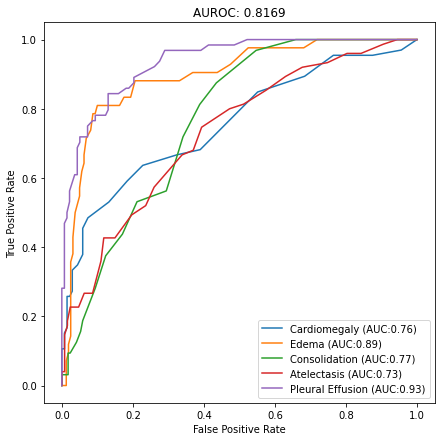

In [109]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

target_labels = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']

fig, ax = plt.subplots(1,1, figsize = (7, 7))
j = 1
aurocs = []
for (i, label) in enumerate(dummy_labels):
  fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), prob_pred[:,i])
  if (label in target_labels):
    #ax = fig.add_subplot(2,3,j)
    ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
    aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))


# Embedding

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/Models/densenet169_model.hdf5')

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

x = model.get_layer('global_average_pooling2d').output 
embedding_model = Model(inputs=model.input, outputs=x)

In [ ]:
def build_embedding_dataset(model,dataset):
  X = model.predict(dataset)
  
  unbatched_dataset = dataset.unbatch()
  Y = []
  for _,labels in unbatched_dataset:
    Y.append(labels.numpy())
  Y = np.array(Y).astype('int')  
  
  return X,Y

In [ ]:
val_X, val_Y = build_embedding_dataset(embedding_model,test_dataset)

In [ ]:
import pandas as pd 
path = '/content/drive/My Drive/Embedding/DenseNet121/validation_densenet121.csv'
df = pd.read_csv(path)

In [ ]:
val_X, val_Y = build_dataset(df)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


n_estimators = [200,500,1000]
max_depth = [5, 15, 30]
min_samples_split = [2, 10, 50]
min_samples_leaf = [1, 5, 10] 
bootstrap = ['True','False']
max_features = ['sqrt','auto']


random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf = RandomForestClassifier(verbose=10,random_state=42)

rf_random = RandomizedSearchCV(estimator = rf,n_iter = 100,
                               scoring='roc_auc', param_distributions= random_grid,
                               cv = 2,  n_jobs = -1,verbose=50)
rf_random.fit(val_X, val_Y.astype('int'))

In [ ]:
rf_random.best_params_

{'bootstrap': 'True',
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 200}

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs=-1,verbose = 10 ,
                             bootstrap= True,max_depth = 30,
                             max_features= 'sqrt',
                             min_samples_leaf= 1,min_samples_split= 10,n_estimators= 200)


In [ ]:
rfc.fit(train_X,train_Y.astype(int))

In [ ]:
test_X, test_Y = build_embedding_dataset(embedding_model,test_dataset)

In [ ]:
predictions = rfc.predict_proba(test_X)
predictions = np.array(predictions)[:,:,1].T

# Embedding Ensemble

In [ ]:
def parse(x):
  return np.array(x.strip('][').split(', '),dtype=np.float32)
  
def build_dataset(df):
  df['Embedding'] = df['Embedding'].apply(lambda x: parse(x))
  values = df['Embedding'].values
  X = np.array([el for el in values])
  Y = df[df.columns[1:-1]].values
  return X, Y 

In [ ]:
import os
model_name = ['DenseNet121','DenseNet169','DenseNet201',
              'VGG16','VGG19','Xception','InceptionResNetV2']
embedding_base_path = 'EmbeddingTrained'
model_base_path = '/content/drive/My Drive/Embedding'

Link alla cartella contenente i modelli trainati: https://drive.google.com/open?id=1FghuuMDHhpNIoEmYlUxMiAngowN3Emke

In [ ]:
from joblib import dump, load
import pandas as pd

def compute_conditional_predictions(predictions):
  predictions[:,5] = predictions[:,3] * predictions[:,5]
  predictions[:,6] = predictions[:,3] * predictions[:,6]
  predictions[:,7] = predictions[:,3] * predictions[:,7]
  predictions[:,4] = predictions[:,3] * predictions[:,4]
  predictions[:,8] = predictions[:,3] * predictions[:,8]
  predictions[:,2] = predictions[:,1] * predictions[:,2]


predictions = []
for name in model_name:
    ##LOAD THE MODEL
    filename = 'embedding_rf_{}.joblib'.format(name.lower())
    model = load(os.path.join(embedding_base_path,filename))
    ##LOAD THE DATA
    dataset_name = 'test_{}.csv'.format(name.lower())

    dataset = pd.read_csv(os.path.join(model_base_path,name,dataset_name))
    test_X, _ = build_dataset(dataset)
    model_pred = model.predict_proba(test_X)
    model_pred = np.array(model_pred)[:,:,1].T
    compute_conditional_predictions(model_pred)
    predictions.append(model_pred)

final_predictions = np.array(predictions)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4

In [ ]:
unbatched_test = test_dataset.unbatch()
test_Y = []
for img, labels in unbatched_test:
  test_Y.append(labels.numpy())
test_Y = np.array(test_Y)

**Ensemble of the 8 Random Forest**

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


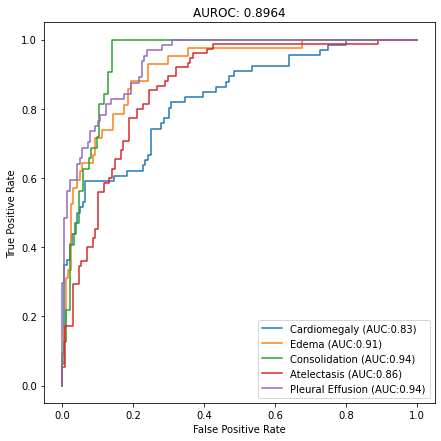

In [ ]:
plot_result(test_Y,np.average(final_predictions,axis=0))

# Conditional Training

In [ ]:
def record_parser(example):
    example_fmt = {
        'label': tf.io.FixedLenFeature([14], tf.float32),
        'image': tf.io.FixedLenFeature([],tf.string, default_value='')}
    parsed = tf.io.parse_single_example(example, example_fmt)
    image = tf.io.decode_png(parsed["image"],channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, parsed['label']

def normalize_image(img,labels):
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    img = (img - imagenet_mean) / imagenet_std
    return img,labels

def make_dataset(filename):
  base_path = '/content/drive/My Drive/tfrecords'
  full_path = os.path.join(base_path,filename)
  dataset = tf.data.TFRecordDataset(full_path)
  parsed_dataset = dataset.map(record_parser,num_parallel_calls = tf.data.experimental.AUTOTUNE)
  parsed_dataset = parsed_dataset.map(normalize_image,num_parallel_calls = tf.data.experimental.AUTOTUNE)
  return parsed_dataset

batch_size = 64
train_dataset = make_dataset('training_cropped.tfrecords').shuffle(buffer_size=128).batch(batch_size, drop_remainder=True).prefetch(1)
val_dataset = make_dataset('validation_cropped.tfrecords').batch(batch_size, drop_remainder=True).prefetch(1)
test_dataset = make_dataset('test_set_cropped.tfrecords').batch(batch_size, drop_remainder=False).prefetch(1)

In [ ]:
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.xception import Xception

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Activation, Lambda
from tensorflow.keras.models import Model

base_model = NASNetMobile(include_top=False,
                             weights='imagenet',
                             input_shape=(224, 224, 3))



x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(14, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
for layer in model.layers[:-1]:
  layer.trainable = False

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

def step_decay(epoch):
  initial_lr = 1e-4
  drop = 0.1
  return initial_lr * np.power(drop,epoch)

outputFolder = '/content/drive/My Drive/ConditionalTraining/NASNetMobile/PreTrained'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath=outputFolder+"/model-{epoch:02d}.hdf5"

lr_scheduler = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_AUC',mode='max',patience=4)
checkpoint_cb = ModelCheckpoint(filepath,save_best_only = False,save_weights_only = False,
                               save_freq='epoch',verbose=False)


opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
callbacks = [lr_scheduler,checkpoint_cb]

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy','AUC'])

In [ ]:
%%time
history = model.fit(train_dataset,
          epochs=5,
          validation_data=val_dataset,
          callbacks=callbacks,
          verbose=1,initial_epoch = 0)

Link alla cartella contenente i modelli trainati: https://drive.google.com/open?id=135mh_ET_e4eiupA-dgv_KaxOPd_RvyQ0

In [ ]:
from tensorflow.keras.models import load_model

model_name = ['DenseNet121','DenseNet169','DenseNet201','VGG16','VGG19','Xception','InceptionResNetV2']

models = []
for el in model_name:
  mod = load_model('/content/drive/My Drive/ConditionalTraining/{}/FineTuning/model-05.hdf5'.format(el))
  models.append(mod)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/core.py:1030: UserWarning: keras_applications.inception_resnet_v2 is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [ ]:
def compute_predictions(model):
  predictions = model.predict(test_dataset)
  predictions[:,5] = predictions[:,3] * predictions[:,5]
  predictions[:,6] = predictions[:,3] * predictions[:,6]
  predictions[:,7] = predictions[:,3] * predictions[:,7]
  predictions[:,4] = predictions[:,3] * predictions[:,4]
  predictions[:,8] = predictions[:,3] * predictions[:,8]
  predictions[:,2] = predictions[:,1] * predictions[:,2]
  return predictions

In [ ]:
nn_predictions = []
for model in models:
  nn_predictions.append(compute_predictions(model))
nn_predictions = np.array(nn_predictions)

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


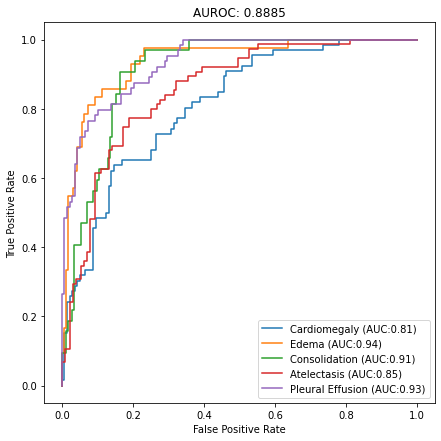

In [ ]:
plot_result(test_Y,np.average(nn_predictions,axis=0))

In [ ]:
from scipy.stats import entropy
nn_entropies = entropy([nn_predictions,1-nn_predictions],base = 2)
nn_pred = np.average(nn_predictions,axis=0, weights=1-nn_entropies)

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


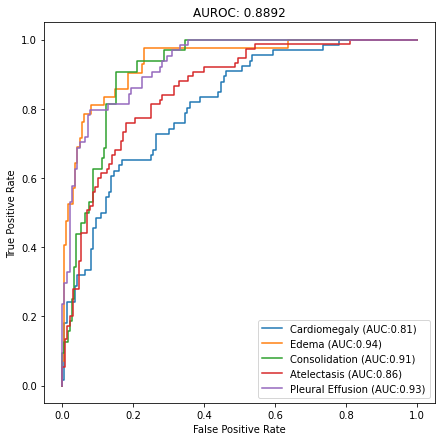

In [ ]:
plot_result(test_Y,nn_pred)

In [ ]:
import pandas as pd 

def parse(x):
  return np.array(x.strip('][').split(', '),dtype=np.float32)
  
def build_dataset(df):
  df['Embedding'] = df['Embedding'].apply(lambda x: parse(x))
  values = df['Embedding'].values
  X = np.array([el for el in values])
  #Y = df[df.columns[1:-1]].values
  return X

# XGBoost

Link alla cartella contenente i modelli trainati: https://drive.google.com/open?id=14GfK5ix7iwtFaRVnz5zXjLGGoT1I9e4v

In [ ]:
import xgboost as xgb
import os
import pandas as pd
model_name = ['DenseNet121','DenseNet169','DenseNet201',
              'VGG16','VGG19','Xception','InceptionResNetV2']
model_base_path = '/content/drive/My Drive/XGBoost'
embedding_base_path = '/content/drive/My Drive/Embedding'

predictions = []
for name in model_name:
  dataset_name = 'test_{}.csv'.format(name.lower())
  dataset = pd.read_csv(os.path.join(embedding_base_path,name,dataset_name))
  test_X = build_dataset(dataset)

  model_pred = []
  dtest = xgb.DMatrix(test_X)
  for i in range(14):
    filename = 'xgboost_lab_{}.joblib'.format(i)
    model = load(os.path.join(model_base_path,name,filename))
    model_pred.append(model.predict(dtest))

  predictions.append(np.array(model_pred).T)


No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


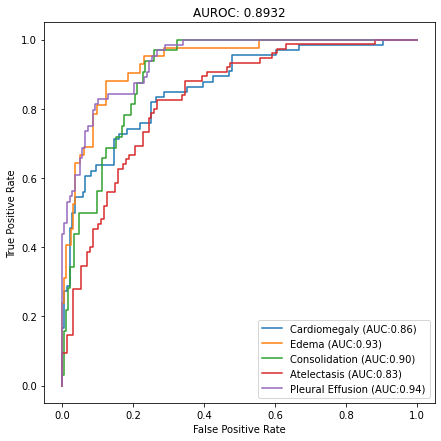

In [ ]:
plot_result(test_Y,np.average(predictions,axis=0))

# Final Result

Link ai file contenenti le predizioni: https://drive.google.com/open?id=1746ztMAbqPrihRUWTuj5iOxcKn27zUQn

In [ ]:
import numpy as np
rf_predictions = np.load('/content/drive/My Drive/Predictions/nn_pred_no_entropy.npy')
nn_predictions = np.load('/content/drive/My Drive/Predictions/rf_pred_no_entropy.npy')
xgb_predictions = np.load('/content/drive/My Drive/Predictions/xgb_pred_no_entropy.npy')

In [ ]:
from scipy.stats import entropy
rf_entropies = entropy([rf_predictions,1-rf_predictions],base = 2)
nn_entropies = entropy([nn_predictions,1-nn_predictions],base = 2)
xgb_entropies = entropy([xgb_predictions,1-xgb_predictions],base = 2)

In [ ]:
rf_pred = np.average(rf_predictions,axis=0, weights=1-rf_entropies)
nn_pred = np.average(nn_predictions,axis=0, weights=1-nn_entropies)
xgb_pred = np.average(xgb_predictions,axis=0,weights=1-xgb_entropies)

In [ ]:
final_predictions = np.average([rf_pred,nn_pred,xgb_pred],axis=0)

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


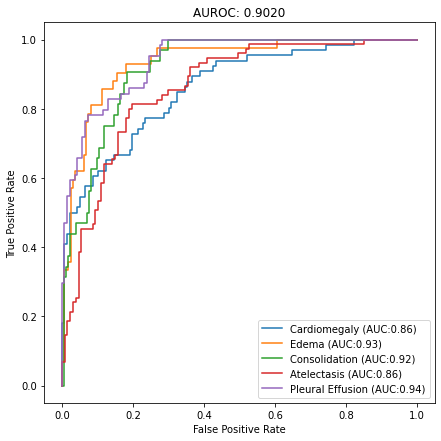

In [ ]:
plot_result(test_Y,final_predictions)

In [ ]:
fin_pred = np.load('/content/drive/My Drive/Predictions/final_predictions.npy')
thresholds = np.load('/content/drive/My Drive/Predictions/thresholds.npy')

for i in range(fin_pred.shape[1]):
  threshold = thresholds[i]
  negative_label = (np.logical_and(fin_pred[:,i] >=0, fin_pred[:,i] <threshold-0.15*threshold))
  uncertain = (np.logical_and(fin_pred[:,i]>=threshold-0.15*threshold, fin_pred[:,i]<=threshold+0.15*threshold))
  positive_label = (np.logical_and(fin_pred[:,i]>=threshold+0.15*threshold, fin_pred[:,i]<=1))
  fin_pred[:,i][negative_label] = 0
  fin_pred[:,i][uncertain] = -1
  fin_pred[:,i][positive_label] = 1


In [ ]:
def compute_confusion_matrix(true_labels,predicted_labels):
  tp = 0 
  tn = 0 
  fp = 0 
  fn = 0 
  uncertain = 0 
  for true,predicted in zip(true_labels,predicted_labels):
    if predicted == -1:
      uncertain += 1
    if true == 1 and predicted == 1:
      tp += 1
    if true == 0 and predicted == 0:
      tn += 1
    if true == 0 and predicted == 1:
      fp +=1
    if true == 1 and predicted == 0:
      fn +=1
  return np.array([[tp,fn],[fp,tn]]),uncertain



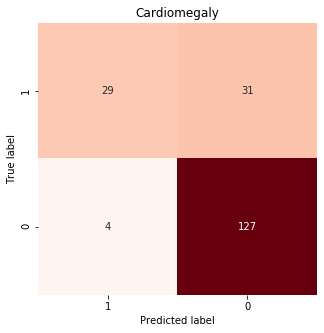

Uncertain labels: 11


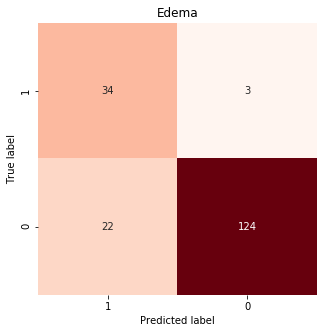

Uncertain labels: 19


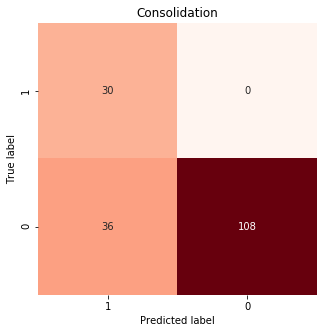

Uncertain labels: 28


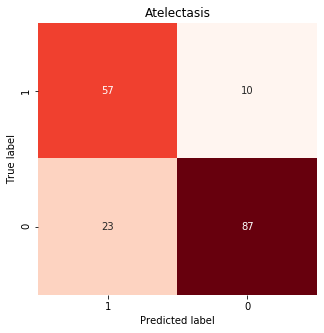

Uncertain labels: 25


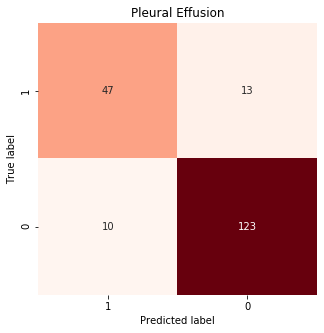

Uncertain labels: 9


In [ ]:
import seaborn as sns

idxs = [2,5,6,8,10]
label_name = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

for i in idxs:
  cm, uncertain = compute_confusion_matrix(test_Y[:,i],fin_pred[:,i])
  fig = plt.figure(figsize=(5,5))
  sns.heatmap(cm,annot=True,fmt='d',cmap='Reds',cbar = False,yticklabels=[1,0],xticklabels=[1,0])
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.title('{}'.format(label_name[i]))
  plt.show()
  spec = cm[1][1] / (cm[1][1] + cm[1][0])
  sensib = cm[0][0] / (cm[0][0] + cm[0][1])
  prec = cm[0][0] / (cm[0][0] + cm[1][0])
  f1 = (2*prec*sensib)/(prec+sensib)
  print('Uncertain labels: {}'.format(uncertain))
 